## Time Series Regression Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#parse datetime with timezone
def parse_datetime_with_timezone(dt_str):
    datetime_str = dt_str[:-3] + dt_str[-2:]
    return pd.to_datetime(datetime_str, utc=True, format="%Y-%m-%d %H:%M:%S%z")

# RE-Write without using "date_parser"
df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')

# If your CSV already has timezone information, you can specify it during parsing
# df = pd.read_csv('data.csv', parse_dates=['timestamp'], index_col='timestamp', date_parser=parse_datetime_with_timezone, tz='America/New_York')

# Make sure this is the right timezone 
df.index = df.index.tz_convert('America/New_York')  # Adjust timezone as per your data

#Set the frequency
#we need to do this before using in STL 
df= df.asfreq(freq='h')

C:\Users\U1231034\AppData\Local\Temp\ipykernel_28348\4174498363.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')


In [3]:
df.drop(columns=["KCPLIATANUNIAT2","KCPLLACYGNEUNLAC2","SECI.KCPS.CIMARRON", "WR.LEC.4", "WR.JEC.2", "WR.JEC.3", "SECI.KCPS.CIMARRON"], inplace=True)

In [4]:
#forecast variable y
#predictor varialbes x1=day of week, x2 = hour of day (x3 = month?)
df["Hour"]=df.index.hour
df["DoW"]=df.index.weekday
df.head()

,KCPLIATANUNIAT1,KCPLLACYGNEUNLAC1,MPS.ROCKCREEK,SECI.KCPS.SPEARVILLE,SECI_CIMARRON,WR.JEC.1,WR.LEC.5,Hour,DoW
Time,,,,,,,,,
2023-01-01 01:00:00-05:00,23.1615,22.2436,22.8559,18.0405,17.3592,17.6536,24.0183,1,6
2023-01-01 02:00:00-05:00,20.5651,19.7729,20.4925,17.3628,17.1675,17.5015,20.8391,2,6
2023-01-01 03:00:00-05:00,22.1197,21.1474,21.9965,18.7383,18.5753,17.5991,22.7795,3,6
2023-01-01 04:00:00-05:00,21.1908,20.2595,21.1168,18.1809,18.0899,17.4774,21.6705,4,6
2023-01-01 05:00:00-05:00,21.9438,20.9770,21.7675,18.8693,18.7861,17.4918,22.6176,5,6


In [ ]:
#NEED TO GET BETTER PREDICTOR VARIABLE TO TEST OUT
lets us temperature and wind speed data for 2023 for Cimarron

In [24]:
cimarron=df[["SECI_CIMARRON"]]
cimarron.head()

,SECI_CIMARRON
Time,
2023-01-01 01:00:00-05:00,17.3592
2023-01-01 02:00:00-05:00,17.1675
2023-01-01 03:00:00-05:00,18.5753
2023-01-01 04:00:00-05:00,18.0899
2023-01-01 05:00:00-05:00,18.7861


In [20]:
cimarron.shape

(8760, 1)

In [7]:
#Get the weather data
weather = pd.read_csv("CimarronWeather23.csv")
weather.head()

,time,temperature,wind_speed
0,2023-01-01T00:00,4.4,31.3
1,2023-01-01T01:00,3.5,28.7
2,2023-01-01T02:00,2.6,25.7
3,2023-01-01T03:00,3.1,28.7
4,2023-01-01T04:00,3.1,28.9


In [8]:
weather.shape

(8760, 3)

In [27]:
cimarron["temp"]=weather["temperature"].values
cimarron["wind"]=weather["wind_speed"].values

C:\Users\U1231034\AppData\Local\Temp\ipykernel_28348\145142433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron["temp"]=weather["temperature"].values
C:\Users\U1231034\AppData\Local\Temp\ipykernel_28348\145142433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron["wind"]=weather["wind_speed"].values


Hold back the last week as the final test set

In [30]:
cimarron_train = cimarron.iloc[:-168]
cimarron_train.tail()

,SECI_CIMARRON,temp,wind
Time,,,
2023-12-24 20:00:00-05:00,-17.8339,2.0,50.4
2023-12-24 21:00:00-05:00,-18.6550,1.7,48.7
2023-12-24 22:00:00-05:00,-19.9816,0.1,48.3
2023-12-24 23:00:00-05:00,-21.0681,-0.3,47.8
2023-12-25 00:00:00-05:00,-23.4609,-0.9,48.7


<Axes: xlabel='Time'>

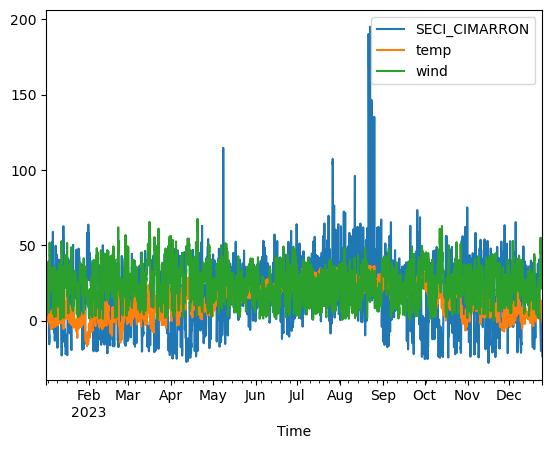

In [45]:
cimarron_train.plot()

<Axes: xlabel='Time'>

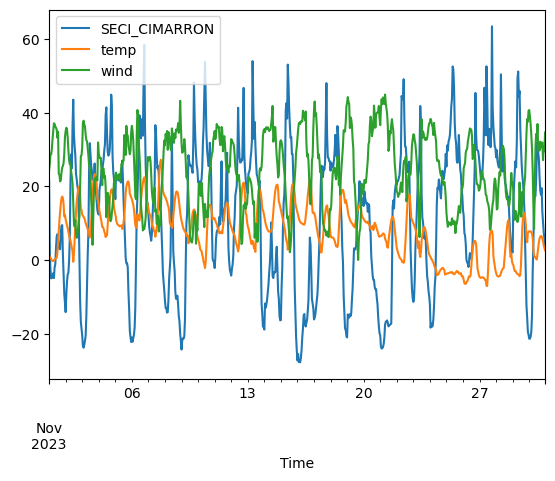

In [54]:
cimarron.loc["2023-11"].plot()

In [31]:
cimarron_test = cimarron.iloc[-168:]

In [33]:
X=cimarron_train.drop("SECI_CIMARRON", axis="columns")

In [35]:
X.shape

(8592, 2)

In [46]:
y=cimarron_train.drop(["temp", "wind"], axis="columns")

In [48]:
y.shape

(8592, 1)

In [ ]:
#how to set up cross validation? 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
# https://scikit-learn.org/stable/modules/cross_validation.html
# https://scikit-learn.org/stable/modules/cross_validation.html

In [39]:
#set up training and tests sets
#gap of 2 days between train and test splits
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import linear_model

In [40]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=1000,
    test_size=500,
)

In [69]:
ols = linear_model.LinearRegression(fit_intercept=False)

In [70]:
cv_results = cross_validate(ols, X, y, cv=ts_cv, scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"], return_estimator=True) 

In [71]:
cv_results

{'fit_time': array([0.00225329, 0.01150656, 0.0065701 , 0.        , 0.00299931]),
 'score_time': array([0.        , 0.0010004 , 0.        , 0.01114249, 0.00400066]),
 'estimator': [LinearRegression(fit_intercept=False),
  LinearRegression(fit_intercept=False),
  LinearRegression(fit_intercept=False),
  LinearRegression(fit_intercept=False),
  LinearRegression(fit_intercept=False)],
 'test_neg_mean_absolute_error': array([-13.95983172, -14.6914183 , -11.36884583,  -9.92408773,
         -9.749905  ]),
 'test_neg_root_mean_squared_error': array([-17.38403479, -18.35985858, -14.15093357, -12.18999657,
        -12.60232163]),
 'test_r2': array([0.22167193, 0.14581245, 0.44994094, 0.60122499, 0.44584943])}

In [72]:
mae = -cv_results["test_neg_mean_absolute_error"]
rmse = -cv_results["test_neg_root_mean_squared_error"]
r2 = cv_results["test_r2"]
print(
    f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    f"R Squared: {r2.mean():.3f} +/- {rmse.std():.3f}")

Mean Absolute Error:     11.939 +/- 2.041
Root Mean Squared Error: 14.937 +/- 2.503
R Squared: 0.373 +/- 2.503


In [73]:
for reg in cv_results["estimator"]:
    print (reg.coef_)

[[12.80131542  1.63108961 -1.17487205]]
[[18.52555526  1.42201273 -1.26146015]]
[[ 4.16970375e+01 -2.79877051e-02 -1.17532113e+00]]
[[49.06957953 -0.57085705 -1.21603377]]
[[51.77106411 -0.67495284 -1.3552791 ]]


In [59]:
import statsmodels.api as sm

In [61]:
X = sm.add_constant(X)

In [62]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          SECI_CIMARRON   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     3065.
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:37:47   Log-Likelihood:                -35562.
No. Observations:                8592   AIC:                         7.113e+04
Df Residuals:                    8589   BIC:                         7.115e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6287      0.459     88.438      0.0

This model is not good at all, but this is more of an excercise in setting the model up and understanding the scores
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [ ]:
#what the heck is a "pipeline"
# https://scikit-learn.org/stable/modules/compose.html

### General Workflow
* pre-process data: pipeline
* split data into training and test set: pandas slicing
* set up cross validation on train set: TimeSeriesSplit
* Model tuning and evaluation: cross_validate
* ?Evaluate model on test set?

### Linear Models

In [ ]:
# Ordinary Least Squares
# https://scikit-learn.org/stable/modules/linear_model.html